In [1]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from random import shuffle

In [2]:
calc = pd.DataFrame()
exp = pd.DataFrame()

for i in os.listdir('stability'):
    
    if 'compare' not in i:
        tmp_calc = pd.read_csv('stability/' + i, index_col=0)
        tmp_calc.sort_index(inplace=True)
        tmp_exp = pd.read_csv('stability/' + i[:-4] + '-compare.csv', index_col=0)
        tmp_exp.sort_index(inplace=True)
        tmp_exp = tmp_exp.loc[tmp_calc.index, :]
        
        calc = pd.concat([calc, tmp_calc])
        exp = pd.concat([exp, tmp_exp])

#calc = pd.read_csv("stability/1stn.csv", index_col=0)
#exp = pd.read_csv("stability/1stn-compare.csv", index_col=0)
exp *= 4.18

In [3]:
data = [((calc['SOLV'][i]+calc['COUL'][i], calc['LJ (1-4)'][i]+calc['LJ (SR)'][i], calc['SAS'][i], calc['-TS'][i]), exp['EXP'][i]) for i in range(len(calc))]

In [4]:
def fit_func2(X, alpha, beta, gamma, tau):
    a, b, c, d = X
    return alpha*a + beta*b + gamma*c + tau*d

In [5]:
def kfold(dataset, k):
    shuffle(dataset)
    n = int(len(dataset) / k)

    for i in range(0, len(dataset), n):
        yield dataset[i:i+n]

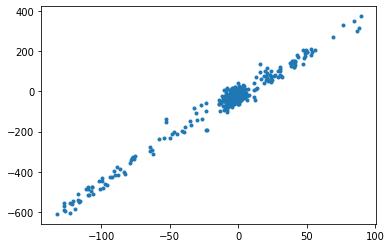

In [18]:
plt.plot(exp["SOLV"], calc["SOLV"], '.')

[[1.         0.74775089]
 [0.74775089 1.        ]]
4.275232765177382


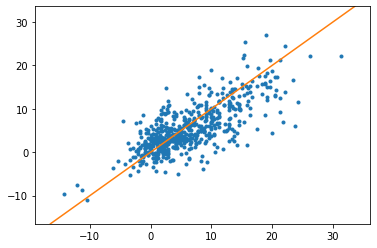

In [6]:
plt.plot(exp['EXP'], exp['CALC'], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
print(np.corrcoef(exp['EXP'], exp['CALC']))
print(np.sqrt(((exp['EXP'] - exp['CALC']) ** 2).mean()))

In [7]:
p0 = [0.224, 0.217, 6.9388, 0.0287]

In [117]:
split = list(kfold(data, 5))
coeff = []

for i in range(5):
    val = split[i]
    train = split.copy()
    train.pop(i)
    train = train[0] + train[1] + train[2] + train[3]
    
    x = np.array(np.array([i[0] for i in train]))
    y = np.array([i[1] for i in train])
    tmp_coeff = curve_fit(fit_func2, (x[:, 0], x[:, 1], x[:, 2], x[:, 3]), y, p0)[0]
    #calc = np.array(np.array([i[0] for i in val]))
    #calc2 = np.array([i[1] for i in val])
    
    #fit = tmp_coeff[0]*calc[:, 0] + tmp_coeff[1]*calc[:, 1] + tmp_coeff[2]*calc[:, 2] + tmp_coeff[3]*calc[:, 3]
    #plt.plot(calc2, fit, '.')
    #plt.plot(plt.xlim(), plt.xlim())
    #plt.show()
    #print(np.corrcoef(calc2, fit))
    
    coeff.append(tmp_coeff)

coeff = np.array(coeff)
print(coeff)
print(coeff.mean(axis=0))
coeff = coeff.mean(axis=0)

[[ 0.22492108  0.39784511  0.94334954  0.01980227]
 [ 0.2339714   0.40528307  0.97751128  0.01495104]
 [ 0.19744519  0.48403343 -1.33153354  0.01170507]
 [ 0.22253134  0.39965593  1.15900734  0.01549292]
 [ 0.22079843  0.42454213  0.1898022   0.00850426]]
[0.21993349 0.42227193 0.38762736 0.01409111]


In [8]:
x = np.array(np.array([i[0] for i in data]))
y = np.array([i[1] for i in data])
coeff = curve_fit(fit_func2, (x[:, 0], x[:, 1], x[:, 2], x[:, 3]), y)[0]
print(coeff)

[0.22249817 0.41614009 0.64933911 0.01774772]


In [9]:
fit = coeff[0] * (calc['SOLV'] + calc['COUL']) + coeff[1] * (calc['LJ (SR)'] + calc['LJ (1-4)']) + coeff[2] * calc['SAS'] + coeff[3] * calc['-TS']

Text(-15, 25, '$\\sigma$ = 4.71$kJ\\,mol^{-1}$')

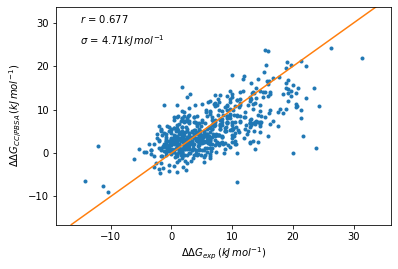

In [10]:
plt.plot(exp['EXP'], fit, '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{exp}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA}\,(kJ\,mol^{-1})$")
plt.text(-15, 30, "$r$ = " + str(np.corrcoef(exp['EXP'], fit)[1][0])[:5])
plt.text(-15, 25, "$\sigma$ = " + str(np.sqrt(((exp['EXP'] - fit) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

# Individual plots

Text(-100, 100, '$\\sigma$ = 4.95$kJ\\,mol^{-1}$')

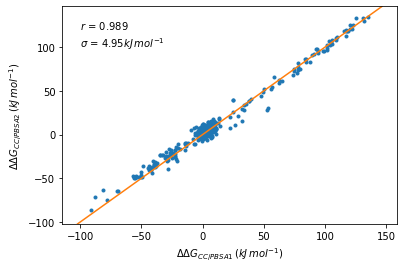

In [11]:
plt.plot(exp['COUL'], calc['COUL']*coeff[0], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-100, 120, "$r$ = " + str(np.corrcoef(exp['COUL'], calc['COUL'])[1][0])[:5])
plt.text(-100, 100, "$\sigma$ = " + str(np.sqrt(((exp['COUL'] - calc['COUL']*p0[0]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(-150, 50, '$\\sigma$ = 6.25$kJ\\,mol^{-1}$')

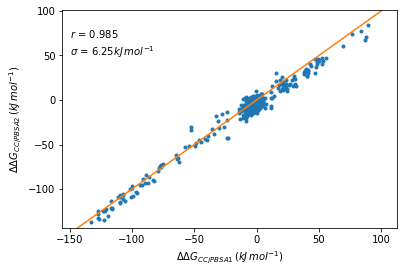

In [12]:
plt.plot(exp['SOLV'], calc['SOLV']*p0[0], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-150, 70, "$r$ = " + str(np.corrcoef(exp['SOLV'], calc['SOLV'])[1][0])[:5])
plt.text(-150, 50, "$\sigma$ = " + str(np.sqrt(((exp['SOLV'] - calc['SOLV']*p0[0]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(-5, 10, '$\\sigma$ = 1.50$kJ\\,mol^{-1}$')

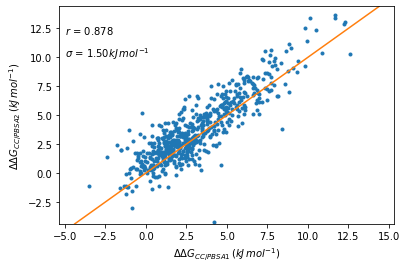

In [139]:
plt.plot(exp['LJ'], (calc['LJ (1-4)']+calc['LJ (SR)'])*p0[1], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-5, 12, "$r$ = " + str(np.corrcoef(exp['LJ'], calc['LJ (1-4)']+calc['LJ (SR)'])[1][0])[:5])
plt.text(-5, 10, "$\sigma$ = " + str(np.sqrt(((exp['LJ'] - (calc['LJ (1-4)']+calc['LJ (SR)'])*p0[1]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(-3, 12, '$\\sigma$ = 2.13$kJ\\,mol^{-1}$')

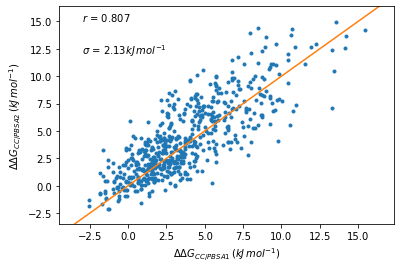

In [124]:
plt.plot(exp['SAS'], calc['SAS']*p0[2], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-3, 15, "$r$ = " + str(np.corrcoef(exp['SAS'], calc['SAS'])[1][0])[:5])
plt.text(-3, 12, "$\sigma$ = " + str(np.sqrt(((exp['SAS'] - calc['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(0, -3.5, '$\\sigma$ = 0.92$kJ\\,mol^{-1}$')

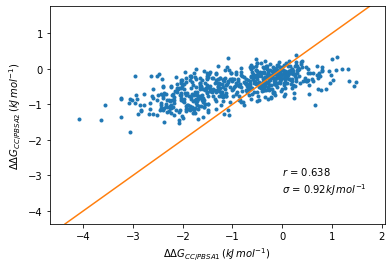

In [140]:
plt.plot(exp['-TS'], calc['-TS']*p0[3], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(0, -3, "$r$ = " + str(np.corrcoef(exp['-TS'], calc['-TS'])[1][0])[:5])
plt.text(0, -3.5, "$\sigma$ = " + str(np.sqrt(((exp['-TS'] - calc['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

In [141]:
def fit(x, a):
    return a*x

curve_fit(fit, calc['-TS'], exp['-TS'])

(array([0.05234762]), array([[2.19272382e-06]]))

## 1ayi

In [17]:
_1ayi = pd.read_csv('stability/1ayi.csv', index_col=0)
_1ayi_exp = pd.read_csv('stability/1ayi-compare.csv', index_col=0)

(0.7495180406727192, 1.0486612703736326e-05)


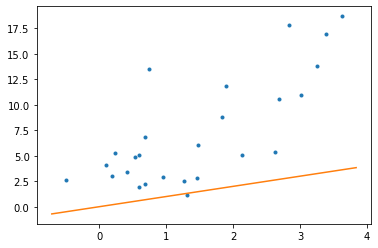

In [18]:
elec = _1ayi['COUL'] + _1ayi['SOLV']
lj = _1ayi['LJ (1-4)'] + _1ayi['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_1ayi['SAS']*coeff[2]+_1ayi['-TS']*coeff[3]
plt.plot(_1ayi_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_1ayi_exp['EXP'], CALC))

Text(-0.6, 0.1, '$\\sigma$ = 0.29$kJ\\,mol^{-1}$')

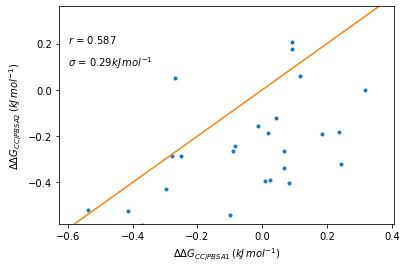

In [19]:
plt.plot(_1ayi_exp['-TS'], _1ayi['-TS']*p0[3], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.6, 0.2, "$r$ = " + str(np.corrcoef(_1ayi_exp['-TS'], _1ayi['-TS'])[1][0])[:5])
plt.text(-0.6, 0.1, "$\sigma$ = " + str(np.sqrt(((_1ayi_exp['-TS'] - _1ayi['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(0, 9, '$\\sigma$ = 3.52$kJ\\,mol^{-1}$')

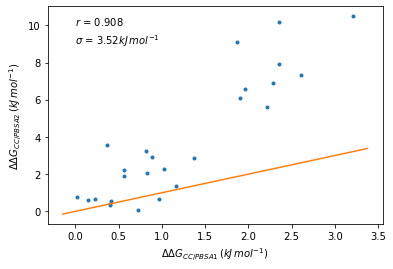

In [20]:
plt.plot(_1ayi_exp['SAS'], _1ayi['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0, 10, "$r$ = " + str(np.corrcoef(_1ayi_exp['SAS'], _1ayi['SAS'])[1][0])[:5])
plt.text(-0, 9, "$\sigma$ = " + str(np.sqrt(((_1ayi_exp['SAS'] - _1ayi['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 1stn

In [21]:
_1stn = pd.read_csv('stability/1stn.csv', index_col=0)
_1stn_exp = pd.read_csv('stability/1stn-compare.csv', index_col=0)

(0.7116851537166138, 3.202071157911485e-42)


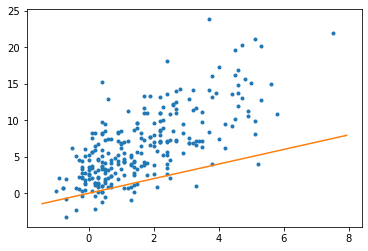

In [22]:
elec = _1stn['COUL'] + _1stn['SOLV']
lj = _1stn['LJ (1-4)'] + _1stn['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_1stn['SAS']*coeff[2]+_1stn['-TS']*coeff[3]
plt.plot(_1stn_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_1stn_exp['EXP'], CALC))

Text(-1, 0.0, '$\\sigma$ = 0.48$kJ\\,mol^{-1}$')

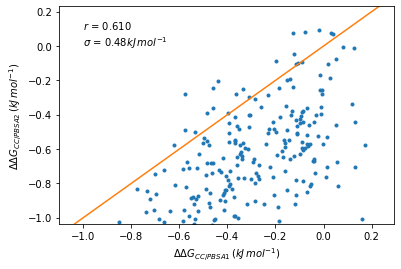

In [23]:
plt.plot(_1stn_exp['-TS'], _1stn['-TS']*p0[3], '.')
plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-1, 0.1, "$r$ = " + str(np.corrcoef(_1stn_exp['-TS'], _1stn['-TS'])[1][0])[:5])
plt.text(-1, 0.0, "$\sigma$ = " + str(np.sqrt(((_1stn_exp['-TS'] - _1stn['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(0, 15, '$\\sigma$ = 5.39$kJ\\,mol^{-1}$')

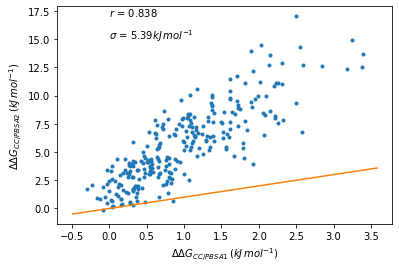

In [24]:
plt.plot(_1stn_exp['SAS'], _1stn['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0, 17, "$r$ = " + str(np.corrcoef(_1stn_exp['SAS'], _1stn['SAS'])[1][0])[:5])
plt.text(-0, 15, "$\sigma$ = " + str(np.sqrt(((_1stn_exp['SAS'] - _1stn['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 2lzm

In [25]:
_2lzm = pd.read_csv('stability/2lzm.csv', index_col=0)
_2lzm_exp = pd.read_csv('stability/2lzm-compare.csv', index_col=0)

(0.24810027080548525, 0.02461345670522449)


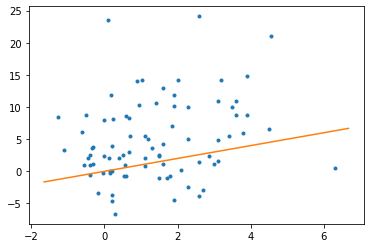

In [26]:
elec = _2lzm['COUL'] + _2lzm['SOLV']
lj = _2lzm['LJ (1-4)'] + _2lzm['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_2lzm['SAS']*coeff[2]+_2lzm['-TS']*coeff[3]
plt.plot(_2lzm_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_2lzm_exp['EXP'], CALC))

Text(-0.6, 0.1, '$\\sigma$ = 0.40$kJ\\,mol^{-1}$')

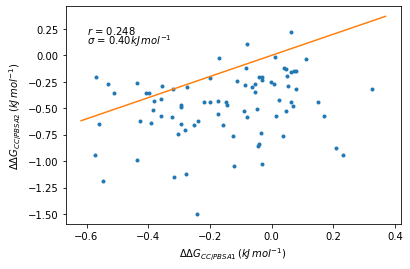

In [27]:
plt.plot(_2lzm_exp['-TS'], _2lzm['-TS']*p0[3], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.6, 0.2, "$r$ = " + str(np.corrcoef(_2lzm_exp['-TS'], _2lzm['-TS'])[1][0])[:5])
plt.text(-0.6, 0.1, "$\sigma$ = " + str(np.sqrt(((_2lzm_exp['-TS'] - _2lzm['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(0, 12, '$\\sigma$ = 3.85$kJ\\,mol^{-1}$')

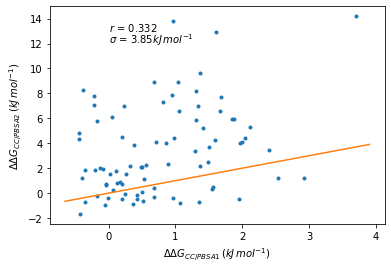

In [28]:
plt.plot(_2lzm_exp['SAS'], _2lzm['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0, 13, "$r$ = " + str(np.corrcoef(_2lzm_exp['SAS'], _2lzm['SAS'])[1][0])[:5])
plt.text(-0, 12, "$\sigma$ = " + str(np.sqrt(((_2lzm_exp['SAS'] - _2lzm['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 3chy

In [29]:
_3chy = pd.read_csv('stability/3chy.csv', index_col=0)
_3chy_exp = pd.read_csv('stability/3chy-compare.csv', index_col=0)

(-0.232892185077544, 0.17818336658796044)


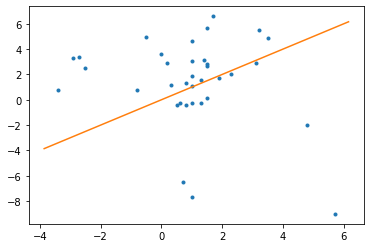

In [30]:
elec = _3chy['COUL'] + _3chy['SOLV']
lj = _3chy['LJ (1-4)'] + _3chy['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_3chy['SAS']*coeff[2]+_3chy['-TS']*coeff[3]
plt.plot(_3chy_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_3chy_exp['EXP'], CALC))

Text(-0.6, 0.1, '$\\sigma$ = 0.25$kJ\\,mol^{-1}$')

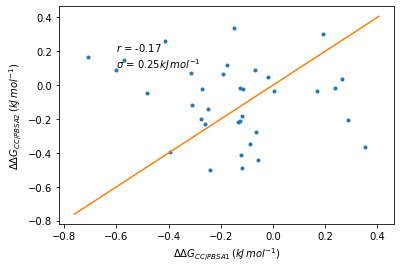

In [31]:
plt.plot(_3chy_exp['-TS'], _3chy['-TS']*p0[3], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.6, 0.2, "$r$ = " + str(np.corrcoef(_3chy_exp['-TS'], _3chy['-TS'])[1][0])[:5])
plt.text(-0.6, 0.1, "$\sigma$ = " + str(np.sqrt(((_3chy_exp['-TS'] - _3chy['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(1.5, 0, '$\\sigma$ = 2.21$kJ\\,mol^{-1}$')

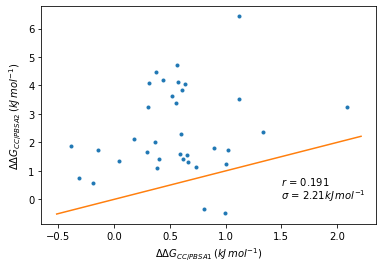

In [32]:
plt.plot(_3chy_exp['SAS'], _3chy['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(1.5, 0.5, "$r$ = " + str(np.corrcoef(_3chy_exp['SAS'], _3chy['SAS'])[1][0])[:5])
plt.text(1.5, 0, "$\sigma$ = " + str(np.sqrt(((_3chy_exp['SAS'] - _3chy['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 1hz6

In [43]:
_1hz6 = pd.read_csv('stability/1hz6.csv', index_col=0)
_1hz6_exp = pd.read_csv('stability/1hz6-compare.csv', index_col=0)

(0.04297981453459014, 0.7278322139556554)


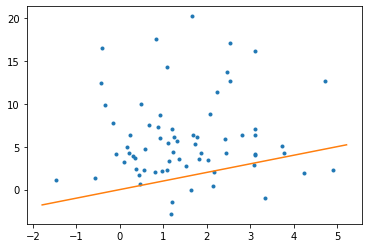

In [46]:
elec = _1hz6['COUL'] + _1hz6['SOLV']
lj = _1hz6['LJ (1-4)'] + _1hz6['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_1hz6['SAS']*coeff[2]+_1hz6['-TS']*coeff[3]
plt.plot(_1hz6_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_1hz6_exp['EXP'], CALC))

Text(-0.8, 0, '$\\sigma$ = 0.19$kJ\\,mol^{-1}$')

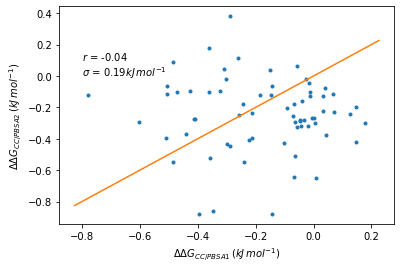

In [34]:
plt.plot(_1hz6_exp['-TS'], _1hz6['-TS']*p0[3], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.8, 0.1, "$r$ = " + str(np.corrcoef(_1hz6_exp['-TS'], _1hz6['-TS'])[1][0])[:5])
plt.text(-0.8, 0, "$\sigma$ = " + str(np.sqrt(((_1hz6_exp['-TS'] - _1hz6['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(1.8, 0, '$\\sigma$ = 3.35$kJ\\,mol^{-1}$')

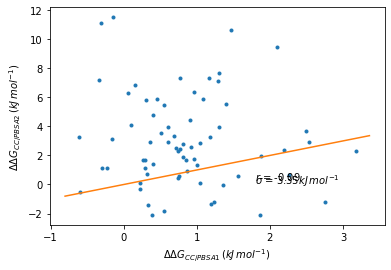

In [35]:
plt.plot(_1hz6_exp['SAS'], _1hz6['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(1.8, 0.3, "$r$ = " + str(np.corrcoef(_1hz6_exp['SAS'], _1hz6['SAS'])[1][0])[:5])
plt.text(1.8, 0, "$\sigma$ = " + str(np.sqrt(((_1hz6_exp['SAS'] - _1hz6['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 1pga

In [36]:
_1pga = pd.read_csv('stability/1pga.csv', index_col=0)
_1pga_exp = pd.read_csv('stability/1pga-compare.csv', index_col=0)

(0.2694489336480107, 0.14989262738816359)


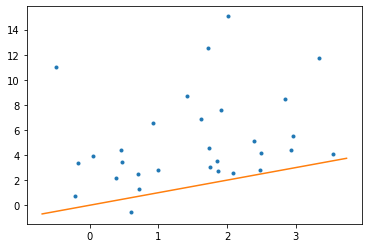

In [47]:
elec = _1pga['COUL'] + _1pga['SOLV']
lj = _1pga['LJ (1-4)'] + _1pga['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_1pga['SAS']*coeff[2]+_1pga['-TS']*coeff[3]
plt.plot(_1pga_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_1pga_exp['EXP'], CALC))

Text(-0.5, 0.0, '$\\sigma$ = 0.17$kJ\\,mol^{-1}$')

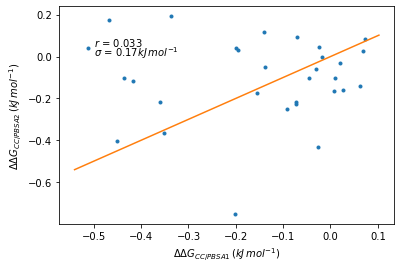

In [37]:
plt.plot(_1pga_exp['-TS'], _1pga['-TS']*p0[3], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.5, 0.05, "$r$ = " + str(np.corrcoef(_1pga_exp['-TS'], _1pga['-TS'])[1][0])[:5])
plt.text(-0.5, 0.0, "$\sigma$ = " + str(np.sqrt(((_1pga_exp['-TS'] - _1pga['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(1.5, 0, '$\\sigma$ = 3.04$kJ\\,mol^{-1}$')

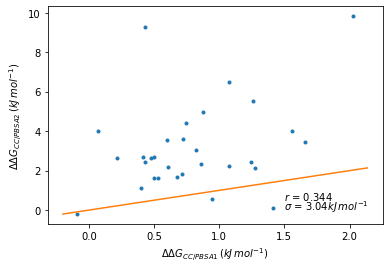

In [38]:
plt.plot(_1pga_exp['SAS'], _1pga['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(1.5, 0.5, "$r$ = " + str(np.corrcoef(_1pga_exp['SAS'], _1pga['SAS'])[1][0])[:5])
plt.text(1.5, 0, "$\sigma$ = " + str(np.sqrt(((_1pga_exp['SAS'] - _1pga['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

## 1ypc

In [20]:
_1ypc = pd.read_csv('stability/1ypc.csv', index_col=0)
_1ypc_exp = pd.read_csv('stability/1ypc-compare.csv', index_col=0)

(0.6475047365355584, 2.595853807929089e-10)


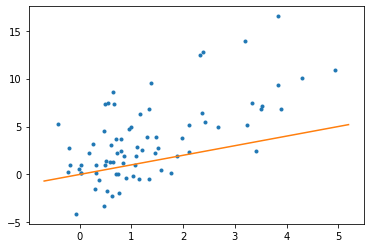

In [21]:
elec = _1ypc['COUL'] + _1ypc['SOLV']
lj = _1ypc['LJ (1-4)'] + _1ypc['LJ (SR)']
CALC = elec*coeff[0]+lj*coeff[1]+_1ypc['SAS']*coeff[2]+_1ypc['-TS']*coeff[3]
plt.plot(_1ypc_exp['EXP'], CALC, '.')
plt.plot(plt.xlim(), plt.xlim())
print(pearsonr(_1ypc_exp['EXP'], CALC))

Text(-0.65, 0.15, '$\\sigma$ = 0.32$kJ\\,mol^{-1}$')

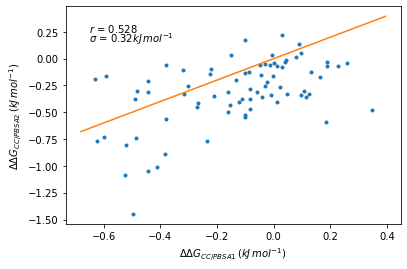

In [22]:
plt.plot(_1ypc_exp['-TS'], _1ypc['-TS']*p0[3], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.65, 0.25, "$r$ = " + str(np.corrcoef(_1ypc_exp['-TS'], _1ypc['-TS'])[1][0])[:5])
plt.text(-0.65, 0.15, "$\sigma$ = " + str(np.sqrt(((_1ypc_exp['-TS'] - _1ypc['-TS']*p0[3]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

Text(-0.5, 11, '$\\sigma$ = 3.30$kJ\\,mol^{-1}$')

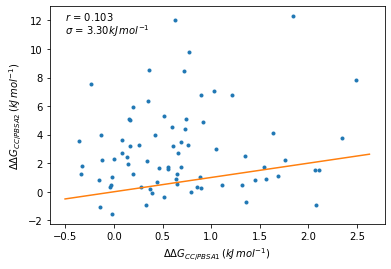

In [41]:
plt.plot(_1ypc_exp['SAS'], _1ypc['SAS']*p0[2], '.')
#plt.ylim(plt.xlim())
plt.plot(plt.xlim(), plt.xlim())
plt.xlabel("$\Delta \Delta G_{CC/PBSA 1}\,(kJ\,mol^{-1})$")
plt.ylabel("$\Delta \Delta G_{CC/PBSA 2}\,(kJ\,mol^{-1})$")
plt.text(-0.5, 12, "$r$ = " + str(np.corrcoef(_1ypc_exp['SAS'], _1ypc['SAS'])[1][0])[:5])
plt.text(-0.5, 11, "$\sigma$ = " + str(np.sqrt(((_1ypc_exp['SAS'] - _1ypc['SAS']*p0[2]) ** 2).mean()))[:4] + "$kJ\,mol^{-1}$")

(0.7705296513874412, 3.9989047411119504e-16)

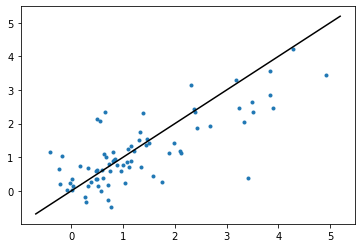

In [138]:
x = pd.read_csv("stability/1ypc-compare.csv", index_col=0)

plt.plot(x['EXP'], x['CALC'], '.')
plt.plot(plt.xlim(), plt.xlim(), 'k')
pearsonr(x['EXP'], x['CALC'])